## Data Import and Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)

In [2]:
midwest_abbrs = ["IL", "IN", "IA", "KS", "MI", "MN", "MO", "NE", "ND", "OH", "SD", "WI"]
midwest_states = ["Illinois", "Indiana", "Iowa", "Kansas", "Michigan", "Minnesota", "Missouri", 
                  "Nebraska", "North Dakota", "Ohio", "South Dakota", "Wisconsin"]

project_state_abbrs = ["IL", "MI", "MO", "OH"]
project_state_names = ["Illinois", "Michigan", "Missouri", "Ohio"]

### Covid 19 Case Data from the New York Times
Generally pretty clean already, but let's just take a look and organize a bit

In [3]:
NYT_df = pd.read_csv("../Raw Data/NYT-us-counties.csv", parse_dates=["date"], dtype={'fips': str, 'cases': int})
NYT_df.shape

(1212589, 6)

In [4]:
NYT_df.describe(datetime_is_numeric=True)

,date,cases,deaths
count,1212589,1212589.00,1185950.00
mean,2020-10-05 14:08:06.898034688,3700.88,79.99
min,2020-01-21 00:00:00,0.00,0.00
25%,2020-07-05 00:00:00,74.00,1.00
50%,2020-10-07 00:00:00,500.00,9.00
75%,2021-01-08 00:00:00,1993.00,40.00
max,2021-04-11 00:00:00,1226456.00,31792.00
std,NaN,19522.54,545.56


Looks like cases data is pretty complete, but there are some NAs for deaths.  Let's investigate...

In [5]:
NYT_df[NYT_df["deaths"].isnull()].head()

,date,county,state,fips,cases,deaths
117486,2020-05-05,Adjuntas,Puerto Rico,72001,3,NaN
117487,2020-05-05,Aguada,Puerto Rico,72003,7,NaN
117488,2020-05-05,Aguadilla,Puerto Rico,72005,11,NaN
117489,2020-05-05,Aguas Buenas,Puerto Rico,72007,22,NaN
117490,2020-05-05,Aibonito,Puerto Rico,72009,13,NaN


According to the documentation, Puerto Rico didn't report deaths at the municipal level, which explains the NA.  That's okay because we'll be narrowing down to the Midwest anyways

Let's look at what other territories were included

In [6]:
np.unique(NYT_df["state"]) # Looks like we have Guam, Northern Mariana Islands, Puerto Rico

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Northern Mariana Islands',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

Cases and deaths data is cumulative, so let's add columns for new cases and death

In [7]:
NYT_df.sort_values(by=["state", "fips", "county", "date"], inplace=True)

NYT_df['new_cases'] = NYT_df.groupby(["state", "fips", "county"])['cases'].diff()
NYT_df['new_deaths'] = NYT_df.groupby(["state", "fips", "county"])['deaths'].diff()

# re-label old columns
NYT_df = NYT_df.rename(columns={"cases": "cumulative_cases", "deaths": "cumulative_deaths"})

NYT_df.head()

,date,county,state,fips,cumulative_cases,cumulative_deaths,new_cases,new_deaths
9480,2020-03-24,Autauga,Alabama,01001,1,0.00,NaN,NaN
10835,2020-03-25,Autauga,Alabama,01001,4,0.00,3.00,0.00
12367,2020-03-26,Autauga,Alabama,01001,6,0.00,2.00,0.00
14025,2020-03-27,Autauga,Alabama,01001,6,0.00,0.00,0.00
15803,2020-03-28,Autauga,Alabama,01001,6,0.00,0.00,0.00


Now lets filter just to midwest states:

In [8]:
NYT_midwest = NYT_df[NYT_df["state"].isin(midwest_states)]

NYT_midwest.shape

(392423, 8)

In [9]:
# Let's make sure every row got a new cases/deaths computed before we fill the first row (which is currently NA) 
# with the cumulative numbers 
NYT_county_counts = NYT_midwest.groupby(["state", "county"]).count()
NYT_county_counts

date  fips  cumulative_cases  cumulative_deaths  \
state     county                                                       
Illinois  Adams       388   388               388                388   
          Alexander   361   361               361                361   
          Bond        379   379               379                379   
          Boone       372   372               372                372   
          Brown       346   346               346                346   
...                   ...   ...               ...                ...   
Wisconsin Waukesha    397   397               397                397   
          Waupaca     381   381               381                381   
          Waushara    371   371               371                371   
          Winnebago   394   394               394                394   
          Wood        392   392               392                392   

                     new_cases  new_deaths  
state     county                            
Illinois  Adams            387         387  
          Alexander        360         360  
          Bond             378         378  
          Boone            371         371  
          Brown            345         345  
...                        ...         ...  
Wisconsin Waukesha         396         396  
          Waupaca          380         380  
          Waushara         370         370  
          Winnebago        393         393  
          Wood             391         391  

[1069 rows x 6 columns]

In [10]:
# Each county should have (# valued new cases) = (# valued dates) - 1
pd.set_option('display.max_rows', None)
NYT_county_counts[NYT_county_counts["new_cases"]!=NYT_county_counts["date"]-1]

date  fips  cumulative_cases  cumulative_deaths  \
state        county                                                         
Illinois     Unknown       270     0               270                270   
Indiana      Unknown         5     0                 5                  5   
Iowa         Unknown       346     0               346                346   
Kansas       Unknown       204     0               204                204   
Michigan     Unknown       381     0               381                381   
Minnesota    Unknown       382     0               382                382   
Missouri     Joplin        291     0               291                291   
             Kansas City   388     0               388                388   
             Unknown        37     0                37                 37   
Nebraska     Unknown       161     0               161                161   
North Dakota Unknown       320     0               320                320   
Ohio         Unknown        42     0                42                 42   
South Dakota Unknown         5     0                 5                  5   
Wisconsin    Unknown       133     0               133                133   

                          new_cases  new_deaths  
state        county                              
Illinois     Unknown              0           0  
Indiana      Unknown              0           0  
Iowa         Unknown              0           0  
Kansas       Unknown              0           0  
Michigan     Unknown              0           0  
Minnesota    Unknown              0           0  
Missouri     Joplin               0           0  
             Kansas City          0           0  
             Unknown              0           0  
Nebraska     Unknown              0           0  
North Dakota Unknown              0           0  
Ohio         Unknown              0           0  
South Dakota Unknown              0           0  
Wisconsin    Unknown              0           0

Looks like each state has a category for Unknown county (which doesn't have a FIPS code which is why new_cases/deaths wasn't calculated.

Kansas City and Joplin straddle multiple counties, which is why they don't have a FIPS code either.
Let's lump these two cities in with the county for which the bulk of the city is in:
- Kansas City -> Jackson County
- Joplin -> Jasper County

In [11]:
# print out before observations so we can check and double check after we collapse
NYT_midwest[(NYT_midwest["county"]=="Jackson") & (NYT_midwest["state"]=="Missouri")].sort_values(by=["date"]).head(10)

,date,county,state,fips,cumulative_cases,cumulative_deaths,new_cases,new_deaths
3497,2020-03-17,Jackson,Missouri,29095,2,0.00,NaN,NaN
4086,2020-03-18,Jackson,Missouri,29095,3,0.00,1.00,0.00
4805,2020-03-19,Jackson,Missouri,29095,3,0.00,0.00,0.00
5640,2020-03-20,Jackson,Missouri,29095,5,1.00,2.00,1.00
6628,2020-03-21,Jackson,Missouri,29095,5,1.00,0.00,0.00
7717,2020-03-22,Jackson,Missouri,29095,5,1.00,0.00,0.00
8905,2020-03-23,Jackson,Missouri,29095,10,1.00,5.00,0.00
10205,2020-03-24,Jackson,Missouri,29095,14,1.00,4.00,0.00
11627,2020-03-25,Jackson,Missouri,29095,17,1.00,3.00,0.00
13225,2020-03-26,Jackson,Missouri,29095,31,1.00,14.00,0.00


In [12]:
NYT_midwest[(NYT_midwest["county"]=="Kansas City") & (NYT_midwest["state"]=="Missouri")].sort_values(by=["date"]).head(10)

,date,county,state,fips,cumulative_cases,cumulative_deaths,new_cases,new_deaths
5641,2020-03-20,Kansas City,Missouri,NaN,12,0.00,NaN,NaN
6631,2020-03-21,Kansas City,Missouri,NaN,13,0.00,NaN,NaN
7720,2020-03-22,Kansas City,Missouri,NaN,13,0.00,NaN,NaN
8908,2020-03-23,Kansas City,Missouri,NaN,18,0.00,NaN,NaN
10209,2020-03-24,Kansas City,Missouri,NaN,30,0.00,NaN,NaN
11631,2020-03-25,Kansas City,Missouri,NaN,51,0.00,NaN,NaN
13229,2020-03-26,Kansas City,Missouri,NaN,64,0.00,NaN,NaN
14954,2020-03-27,Kansas City,Missouri,NaN,78,0.00,NaN,NaN
16778,2020-03-28,Kansas City,Missouri,NaN,94,0.00,NaN,NaN
18700,2020-03-29,Kansas City,Missouri,NaN,102,0.00,NaN,NaN


In [13]:
NYT_midwest.loc[NYT_midwest["county"]=="Kansas City", 'fips'] = "29095"
NYT_midwest.loc[NYT_midwest["county"]=="Kansas City", 'county'] = "Jackson"
NYT_midwest.loc[NYT_midwest["county"]=="Joplin", 'fips'] = "29097"
NYT_midwest.loc[NYT_midwest["county"]=="Joplin", 'county'] = "Jasper"

# collapse Kansas City and Joplin observations with the rest of the counties
NYT_midwest["fips"] = NYT_midwest["fips"].fillna("-1") # so na's don't get lost in the groupby
NYT_midwest = NYT_midwest.groupby(["state", "fips", "county", "date"]).agg('sum')

# recalculate new cases and deaths
NYT_midwest['new_cases'] = NYT_midwest.groupby(["state", "fips", "county"])['cumulative_cases'].diff()
NYT_midwest['new_deaths'] = NYT_midwest.groupby(["state", "fips", "county"])['cumulative_deaths'].diff()
NYT_midwest.reset_index(inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [14]:
# print out after observations so we can check and double check collapse
NYT_midwest[(NYT_midwest["county"]=="Jackson") & (NYT_midwest["state"]=="Missouri")].sort_values(by=["date"]).head(10)
# looks correct!

,state,fips,county,date,cumulative_cases,cumulative_deaths,new_cases,new_deaths
231144,Missouri,29095,Jackson,2020-03-17,2,0.00,NaN,NaN
231145,Missouri,29095,Jackson,2020-03-18,3,0.00,1.00,0.00
231146,Missouri,29095,Jackson,2020-03-19,3,0.00,0.00,0.00
231147,Missouri,29095,Jackson,2020-03-20,17,1.00,14.00,1.00
231148,Missouri,29095,Jackson,2020-03-21,18,1.00,1.00,0.00
231149,Missouri,29095,Jackson,2020-03-22,18,1.00,0.00,0.00
231150,Missouri,29095,Jackson,2020-03-23,28,1.00,10.00,0.00
231151,Missouri,29095,Jackson,2020-03-24,44,1.00,16.00,0.00
231152,Missouri,29095,Jackson,2020-03-25,68,1.00,24.00,0.00
231153,Missouri,29095,Jackson,2020-03-26,95,1.00,27.00,0.00


In [15]:
# check to make sure that everybody has new_cases computed now (except for the first rows of each county)
NYT_county_counts = NYT_midwest.groupby(["state", "county"]).count()
print("Discrepancies: %d" % len(NYT_county_counts[NYT_county_counts["new_cases"]!=NYT_county_counts["date"]-1]))

Discrepancies: 0


In [16]:
# fill in the NA's of new_cases/deaths with the cumulative value for the first day
NYT_midwest["new_cases"] = NYT_midwest["new_cases"].fillna(NYT_midwest["cumulative_cases"])
NYT_midwest["new_deaths"] = NYT_midwest["new_deaths"].fillna(NYT_midwest["cumulative_deaths"])

Let's look at what proportion of the unknowns of each state represent

In [17]:
# Let's figure out how many cases are lumped into unknown for each state
NYT_unknown_cumulative = NYT_midwest[NYT_midwest["county"]=='Unknown'].groupby(["county", "state"])\
                                                                      .agg('max')\
                                                                      .reset_index(level=0, drop=True)\
                                                                      [['cumulative_cases', 'cumulative_deaths']]

NYT_state_cumulative = NYT_midwest[NYT_midwest["date"]=='04-11-2021'].groupby(["state"])\
                                                                     .agg('sum')\
                                                                     [['cumulative_cases', 'cumulative_deaths']]

merged_cumulatives = NYT_unknown_cumulative.merge(NYT_state_cumulative, left_index=True, right_index=True)
merged_cumulatives["percent_unknown_cases"] = merged_cumulatives["cumulative_cases_x"]/merged_cumulatives["cumulative_cases_y"]
merged_cumulatives["percent_unknown_deaths"] = merged_cumulatives["cumulative_deaths_x"]/merged_cumulatives["cumulative_deaths_y"]
merged_cumulatives


,cumulative_cases_x,cumulative_deaths_x,cumulative_cases_y,cumulative_deaths_y,percent_unknown_cases,percent_unknown_deaths
state,,,,,,
Illinois,12048,292.00,1283110,23793.00,0.01,0.01
Indiana,2,0.00,701988,13148.00,0.00,0.00
Iowa,3810,5.00,357019,5857.00,0.01,0.00
Kansas,0,1107.00,306518,4938.00,0.00,0.22
Michigan,8855,46.00,819977,17552.00,0.01,0.00
Minnesota,799,78.00,542131,7035.00,0.00,0.01
Missouri,153,0.00,591975,9007.00,0.00,0.00
Nebraska,587,4.00,214323,2330.00,0.00,0.00
North Dakota,2346,42.00,104776,1502.00,0.02,0.03


Unknowns seems like a very small percentage EXCEPT for Kansas unknown deaths, which is pretty significant (22%).  Thankfully, Kansas isn't one of our final states, so I think it's fine if we just drop observations that have unknown county.

In [18]:
NYT_midwest = NYT_midwest[NYT_midwest["county"]!='Unknown']

Let's visualize data by state and check for outliers

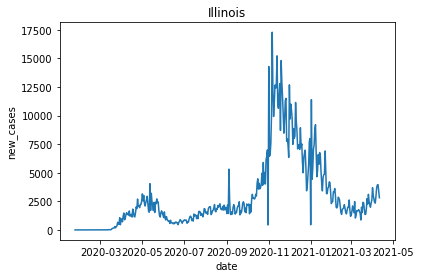

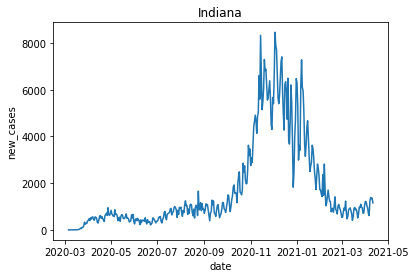

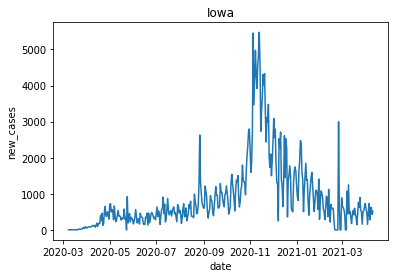

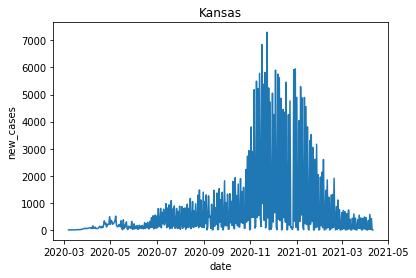

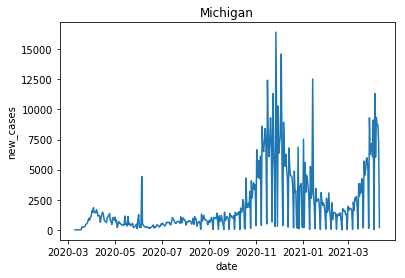

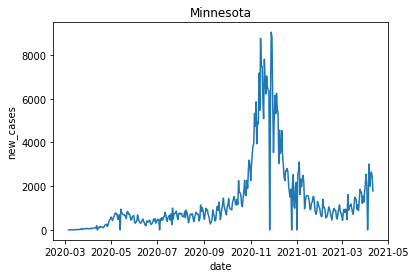

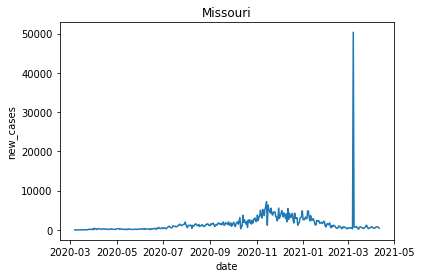

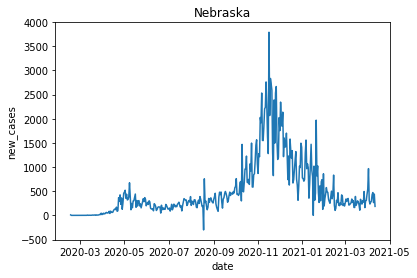

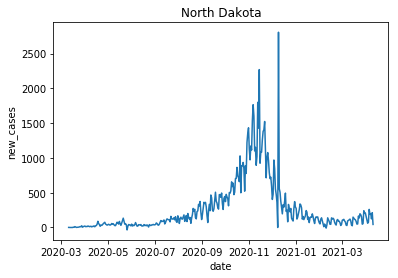

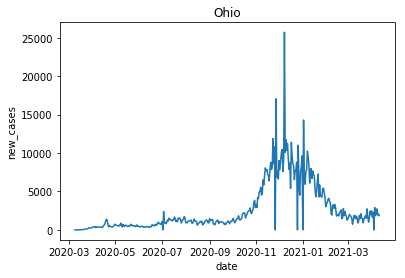

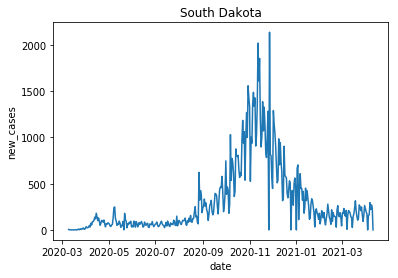

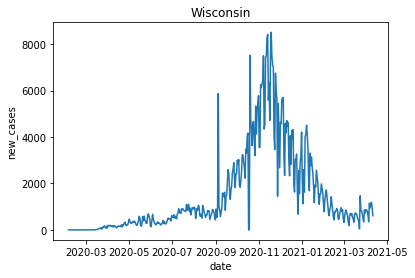

In [19]:
NYT_midwest_states_plt = NYT_midwest.groupby(["state", "date"]).agg("sum")

NYT_midwest_states_plt.reset_index(inplace=True)
NYT_midwest_states_plt.set_index("date", inplace=True)

for state in midwest_states:
    plt.figure()
    plt_data = NYT_midwest_states_plt[NYT_midwest_states_plt["state"]==state]
    sns.lineplot(data=plt_data, x=plt_data.index, y="new_cases")
    plt.title(state)

In [20]:
# investigate negative cases
# NYT_midwest[(NYT_midwest["new_cases"]<0) & (NYT_midwest["county"]!= "Unknown")].sort_values(by=["new_cases"])
# NYT_midwest_imputed[(NYT_midwest_imputed["new_cases"]<0) & (NYT_midwest_imputed["county"]!= "Unknown")].sort_values(by=["new_cases"])

Checked a few outliers:
- Missouri 3/8/2021: The state decided to report a bunch of positive tests they weren't previously counting
- Spot checked some negative new cases/deaths, and it seems like the new cases/deaths calculation is correct and the issues are with the original raw cumulative values
- Checked the noise for Kansas and Michigan and it seems present in the raw data


Now let's check missingness by county

In [21]:
print("# counties in the dataset for the midwest: %d" % len(NYT_midwest[["county", "state"]].drop_duplicates()))
print("# days covered in this data: %d" % len(NYT_midwest["date"].unique()))

# counties in the dataset for the midwest: 1055
# days covered in this data: 444


In [22]:
NYT_midwest.describe()

,cumulative_cases,cumulative_deaths,new_cases,new_deaths
count,389458.00,389458.00,389458.00,389458.00
mean,2503.99,46.86,17.27,0.29
std,11354.53,255.94,82.15,2.17
min,1.00,0.00,-309.00,-155.00
25%,50.00,0.00,0.00,0.00
50%,373.00,6.00,2.00,0.00
75%,1596.00,29.00,10.00,0.00
max,512773.00,10310.00,10809.00,277.00


In [23]:
pd.set_option('display.max_rows', None)
NYT_midwest.groupby(["state", "county"]).count().describe()

,fips,date,cumulative_cases,cumulative_deaths,new_cases,new_deaths
count,1055.00,1055.00,1055.00,1055.00,1055.00,1055.00
mean,369.15,369.15,369.15,369.15,369.15,369.15
std,30.40,30.40,30.40,30.40,30.40,30.40
min,190.00,190.00,190.00,190.00,190.00,190.00
25%,366.00,366.00,366.00,366.00,366.00,366.00
50%,379.00,379.00,379.00,379.00,379.00,379.00
75%,386.00,386.00,386.00,386.00,386.00,386.00
max,444.00,444.00,444.00,444.00,444.00,444.00


I'm assuming each state/county started reported covid data at different dates, which is fine since it seems like most counties report data for at least a year (besides unknowns).  Spot checked a few of the counties with less days of data are smaller counties that didn't have any cases until later.

### Data Summary and To Dos

#### Summary
- Data seems pretty complete and everything looks good for using this data

### Standardize cases data

In [24]:
# compute 7 day average
NYT_7avg = NYT_midwest[["state", "date", "fips", "county", "new_cases", "new_deaths"]]\
    .set_index("date")\
    .groupby(["state", "fips", "county"])\
    .rolling(7, min_periods=1).mean().round(0).reset_index()\
    .rename(columns={'new_cases': 'new_cases_7avg', 
                     'new_deaths': 'new_deaths_7avg'})

# merge on 7 day average
NYT_clean = NYT_midwest.merge(NYT_7avg, on=["state", "fips", "date", "county"])

# calculate 2 week lag variables
NYT_clean["2weeksago_cases_7avg"]= NYT_clean.groupby(["state", "fips", "county"])['new_cases_7avg']\
                                            .shift(14)

NYT_clean["2weeksago_cases_7avg"] = NYT_clean["2weeksago_cases_7avg"].fillna(0)

# check that things were computed correctly
NYT_clean[(NYT_clean["fips"]=="17031") & (NYT_clean["date"]>"2020-07-01")].head(30)

,state,fips,county,date,cumulative_cases,cumulative_deaths,new_cases,new_deaths,new_cases_7avg,new_deaths_7avg,2weeksago_cases_7avg
5774,Illinois,17031,Cook,2020-07-02,91381,4609.00,470.00,28.00,390.00,16.00,314.00
5775,Illinois,17031,Cook,2020-07-03,91774,4618.00,393.00,9.00,387.00,13.00,329.00
5776,Illinois,17031,Cook,2020-07-04,92240,4622.00,466.00,4.00,405.00,12.00,329.00
5777,Illinois,17031,Cook,2020-07-05,92532,4627.00,292.00,5.00,397.00,12.00,324.00
5778,Illinois,17031,Cook,2020-07-06,92781,4630.00,249.00,3.00,380.00,11.00,320.00
5779,Illinois,17031,Cook,2020-07-07,93053,4651.00,272.00,21.00,360.00,12.00,321.00
5780,Illinois,17031,Cook,2020-07-08,93496,4664.00,443.00,13.00,369.00,12.00,326.00
5781,Illinois,17031,Cook,2020-07-09,94005,4676.00,509.00,12.00,375.00,10.00,353.00
5782,Illinois,17031,Cook,2020-07-10,94605,4693.00,600.00,17.00,404.00,11.00,360.00
5783,Illinois,17031,Cook,2020-07-11,95138,4711.00,533.00,18.00,414.00,13.00,360.00


In [25]:
# Narrow down to just the four states
NYT_clean = NYT_clean[NYT_clean["state"].isin(project_state_names)]
np.unique(NYT_clean["state"])

array(['Illinois', 'Michigan', 'Missouri', 'Ohio'], dtype=object)

In [26]:
# make state abbreviations
NYT_clean['state_abbr'] = "IL"
NYT_clean.loc[NYT_clean['state']=="Missouri", 'state_abbr'] = 'MO'
NYT_clean.loc[NYT_clean['state']=="Ohio", 'state_abbr'] = 'OH'
NYT_clean.loc[NYT_clean['state']=="Michigan", 'state_abbr'] = 'MI'

# make sure things mapped correctly
print(NYT_clean[["state_abbr", "state"]].drop_duplicates())

# rename
NYT_clean = NYT_clean.drop(columns=["state"]).rename(columns={"state_abbr": "state"})
NYT_clean = NYT_clean[NYT_clean.columns.tolist()[-1:] + NYT_clean.columns.tolist()[:-1]]

       state_abbr     state
0              IL  Illinois
148085         MI  Michigan
212123         MO  Missouri
305113         OH      Ohio


In [27]:
# export to folder
NYT_clean.to_csv("../Clean Data/NYT_clean.csv", index=False)

## Variant Data from Helix

From Helix documentation: "Drawing from samples collected during routine lower-nasal swab COVID-19 testing, typically at Helix-supported testing sites across the country, a subset of positive samples are chosen for follow-on sequencing based on demographics, sample quality, test characteristics, or simply random selection."

Because Helix only sequences a sample of their positive cases, I think we should only use Helix for the "Number of positive test results with S gene target failure" (variable name "all_SGTF") and not the variables involving sequencing.  S gene target failure is theorized to be a marker for B117 but it's definitely not exact, but I think as good as we can do with this data. (https://jamanetwork.com/journals/jama/fullarticle/2778599)

This data is also on the state level rather than the county level.

In [28]:
helix = pd.read_csv("../Raw Data/helix.csv", parse_dates=["collection_date"])
helix.head()

,state,collection_date,positive,all_SGTF,sequenced_SGTF,B117
0,PR,2020-09-05,3,0,0,0
1,VA,2020-09-05,3,0,0,0
2,FL,2020-09-06,8,0,0,0
3,CA,2020-09-07,8,0,0,0
4,AL,2020-09-08,3,0,0,0


In [29]:
helix.shape

(3927, 6)

In [30]:
helix_midwest = helix[helix["state"].isin(midwest_abbrs)]
helix_midwest.shape

(978, 6)

In [31]:
helix_midwest.head()

,state,collection_date,positive,all_SGTF,sequenced_SGTF,B117
7,IL,2020-09-08,4,0,0,0
9,MO,2020-09-08,3,0,0,0
10,OH,2020-09-08,3,0,0,0
26,MN,2020-09-12,4,0,0,0
38,IL,2020-09-15,6,0,0,0


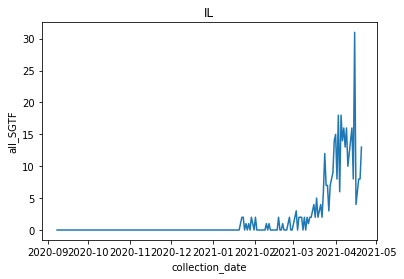

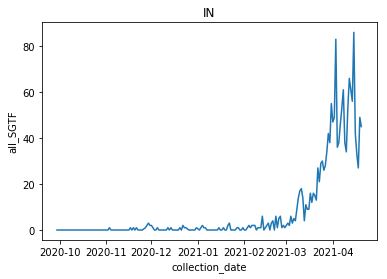

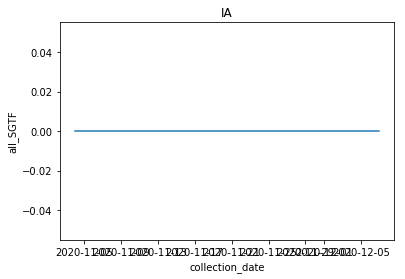

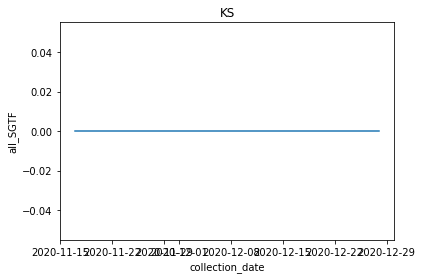

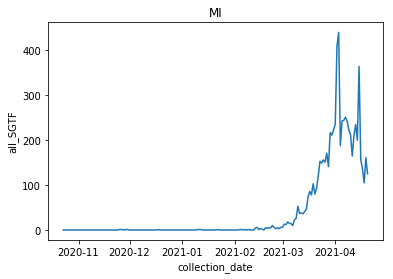

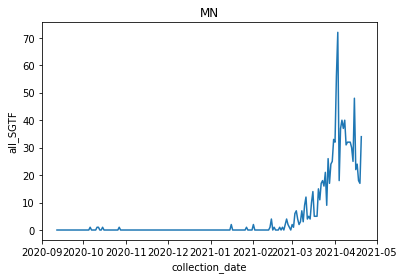

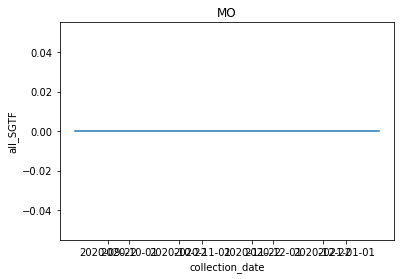

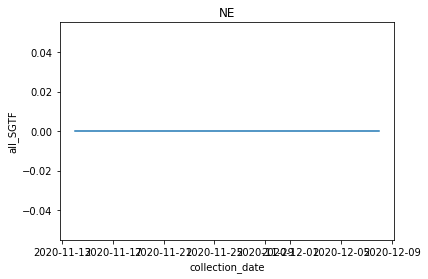

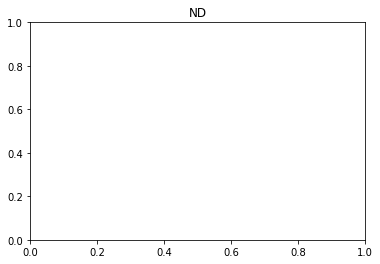

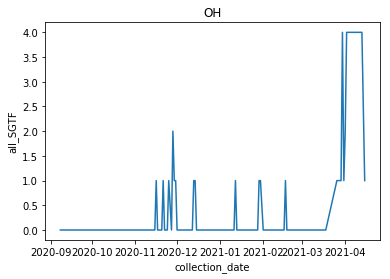

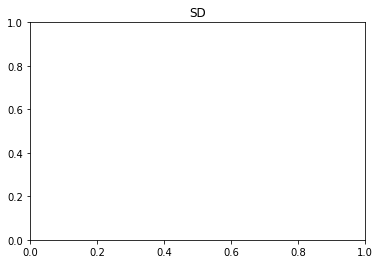

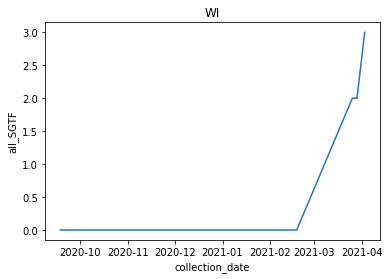

In [32]:
helix_midwest.set_index("collection_date", inplace=True)
for state in midwest_abbrs:
    plt.figure()
    plt_data = helix_midwest[helix_midwest["state"]==state]
    sns.lineplot(data=plt_data, x=plt_data.index, y="all_SGTF")
    plt.title(state)

In [33]:
# check whether SD and ND are just absent from the data
np.unique(helix_midwest.state)

array(['IA', 'IL', 'IN', 'KS', 'MI', 'MN', 'MO', 'NE', 'OH', 'WI'],
      dtype=object)

So it appears that North Dakota and South Dakota are just absent from this Helix data.  This would be an issue if we were to use Helix as the only form of variant data.

Looks like the rate of variants is just very varied across states generally

In [34]:
# let's make cumulative columns
cumulative_all_SGTF = helix_midwest[["state", "all_SGTF", "B117"]].groupby(['state','collection_date']).sum() \
                                                          .groupby(level=0).cumsum().reset_index()
cumulative_all_SGTF.rename(columns={"all_SGTF": "cumulative_SGTF", "B117" : "cumulative_B117"}, inplace=True)

helix_midwest = helix_midwest.merge(cumulative_all_SGTF, on=["state", "collection_date"])

helix_midwest.head()

,state,collection_date,positive,all_SGTF,sequenced_SGTF,B117,cumulative_SGTF,cumulative_B117
0,IL,2020-09-08,4,0,0,0,0,0
1,MO,2020-09-08,3,0,0,0,0,0
2,OH,2020-09-08,3,0,0,0,0,0
3,MN,2020-09-12,4,0,0,0,0,0
4,IL,2020-09-15,6,0,0,0,0,0


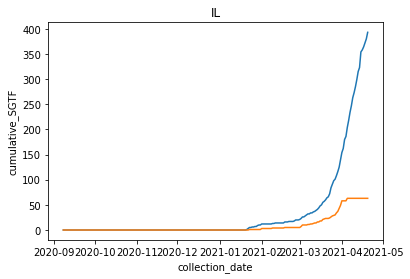

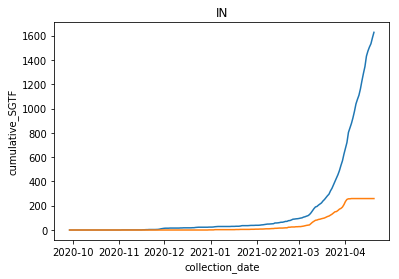

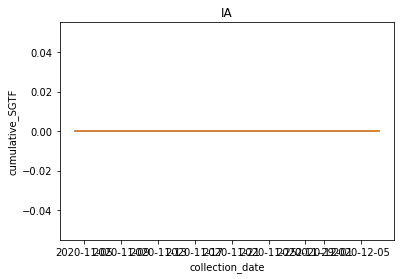

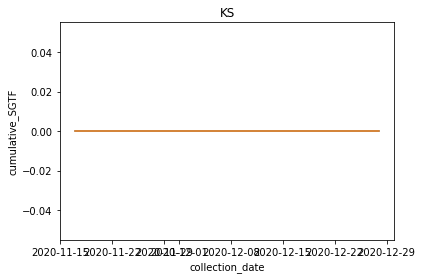

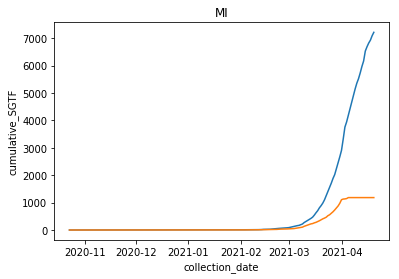

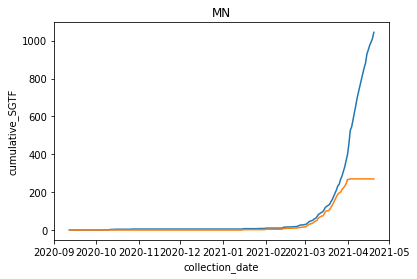

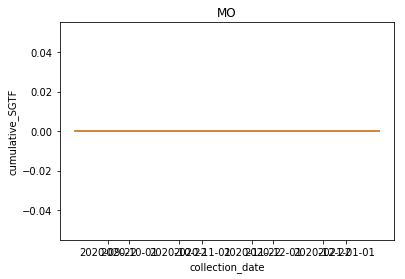

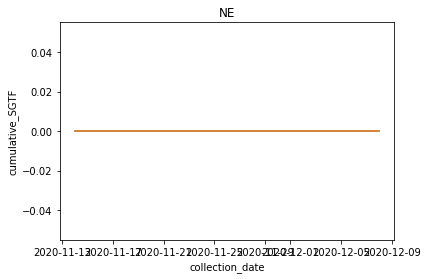

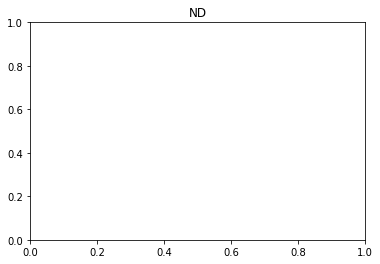

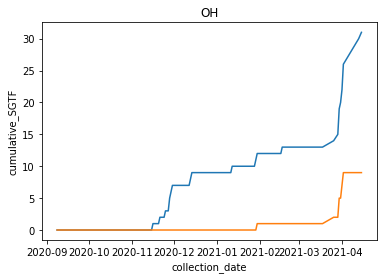

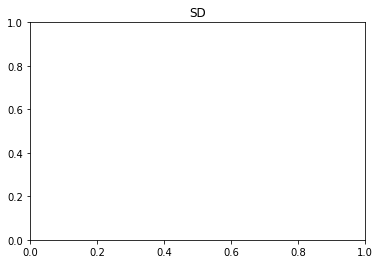

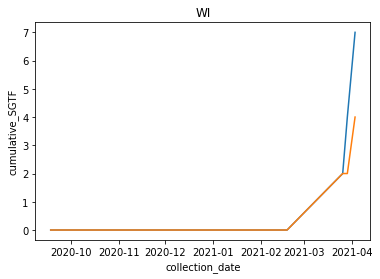

In [35]:
helix_midwest.set_index("collection_date", inplace=True)
for state in midwest_abbrs:
    plt.figure()
    plt_data = helix_midwest[helix_midwest["state"]==state]
    sns.lineplot(data=plt_data, x=plt_data.index, y="cumulative_SGTF")
    sns.lineplot(data=plt_data, x=plt_data.index, y="cumulative_B117")
    plt.title(state)

I don't think the Wisconsin data is complete because this data reports that they only have a handful of variant cases but the Wisconsin DHS definitely reports a lot more (https://www.dhs.wisconsin.gov/covid-19/variants.htm).

### Data Summary and To Dos

#### Summary
- Data is missing for ND and SD entirely
- Data looks very incomplete for Wisconsin
- Generally data seems a pretty unreliable upon matching against CDC current cumulative numbers: https://www.cdc.gov/coronavirus/2019-ncov/transmission/variant-cases.html Doesn't seem like it's a consistant subsample across states so not sure how usable this is...

#### To Do:
- Maybe check the CDC page again for their data?  Or hopefully the GISAid data will be more helpful

## CMS Data on Public Mask Mandates

Source: https://data.cdc.gov/Policy-Surveillance/U-S-State-and-Territorial-Public-Mask-Mandates-Fro/62d6-pm5i
"State and territorial executive orders, administrative orders, resolutions, and proclamations are collected from government websites" 

In [36]:
Masks_df = pd.read_csv("../Raw Data/CMS-Public_Mask_Mandates.csv", parse_dates=["date"])
Masks_df.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (8,9,10,11,13,14,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Current_order_status,Jurisdiction_Type,Issuing_Jurisdiction,Face_Masks_Required_in_Public,Effective_date,Expiration_date,Effective_NA_Reason,Expiration_NA_Reason,Date_Signed,origin_dataset,Source_of_Action,URL,Citation
0,AL,Autauga County,1,1,2020-04-10,2,No Public Mask Mandate,State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AL,Autauga County,1,1,2020-04-11,2,No Public Mask Mandate,State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AL,Autauga County,1,1,2020-04-12,2,No Public Mask Mandate,State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AL,Autauga County,1,1,2020-04-13,2,No Public Mask Mandate,State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AL,Autauga County,1,1,2020-04-14,2,No Public Mask Mandate,State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lots of interesting variables.  Let's explore...

In [37]:
Midwest_Masks_df = Masks_df[Masks_df["State_Tribe_Territory"].isin(midwest_abbrs)]
Midwest_Masks_df.shape

(366085, 19)

In [38]:
# Let's look at the types of mask orders
np.unique(Midwest_Masks_df.Current_order_status) # okay so basically just a binary

array(['No Public Mask Mandate', 'Public Mask Mandate'], dtype=object)

In [39]:
# Let's look at the different jurisdiction types
np.unique(Midwest_Masks_df.Jurisdiction_Type) # hmmmm just state

array(['State'], dtype=object)

In [40]:
# Let's look at the different jurisdiction types for all states
np.unique(Masks_df.Jurisdiction_Type) # okay so basically just literally state or territory level

array(['District (state)', 'State', 'Territory'], dtype=object)

In [41]:
Masks_df[Masks_df["Jurisdiction_Type"]=="District (state)"].head(3)

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Current_order_status,Jurisdiction_Type,Issuing_Jurisdiction,Face_Masks_Required_in_Public,Effective_date,Expiration_date,Effective_NA_Reason,Expiration_NA_Reason,Date_Signed,origin_dataset,Source_of_Action,URL,Citation
84890,DC,District of Columbia,11,1,2020-05-16,1,Public Mask Mandate,District (state),DC,Yes,2020-05-16,2020-06-08,NaN,NaN,2020-05-13,state.terr,Official,https://www.dcregs.dc.gov/Common/NoticeDetail....,"D.C. Mayor's Order No. 2020-066 (May 13, 2020)"
84891,DC,District of Columbia,11,1,2020-05-17,1,Public Mask Mandate,District (state),DC,Yes,2020-05-16,2020-06-08,NaN,NaN,2020-05-13,state.terr,Official,https://www.dcregs.dc.gov/Common/NoticeDetail....,"D.C. Mayor's Order No. 2020-066 (May 13, 2020)"
84892,DC,District of Columbia,11,1,2020-05-18,1,Public Mask Mandate,District (state),DC,Yes,2020-05-16,2020-06-08,NaN,NaN,2020-05-13,state.terr,Official,https://www.dcregs.dc.gov/Common/NoticeDetail....,"D.C. Mayor's Order No. 2020-066 (May 13, 2020)"


In [42]:
Masks_df[Masks_df["Jurisdiction_Type"]=="Territory"].head(3)

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Current_order_status,Jurisdiction_Type,Issuing_Jurisdiction,Face_Masks_Required_in_Public,Effective_date,Expiration_date,Effective_NA_Reason,Expiration_NA_Reason,Date_Signed,origin_dataset,Source_of_Action,URL,Citation
835772,AS,Eastern District,60,10,2020-04-10,2,No Public Mask Mandate,Territory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835773,AS,Eastern District,60,10,2020-04-11,2,No Public Mask Mandate,Territory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835774,AS,Eastern District,60,10,2020-04-12,2,No Public Mask Mandate,Territory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Soooo basically this data is on the state level.  Which is still helpful.  Let's just check dates/trends

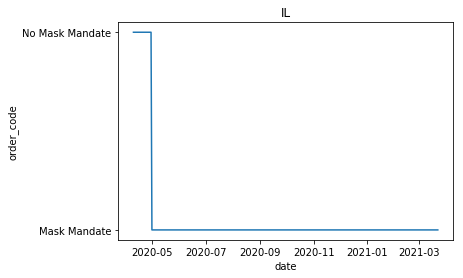

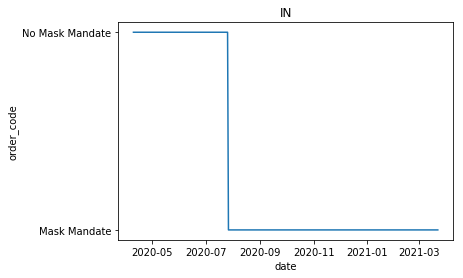

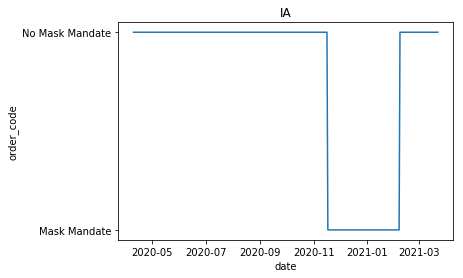

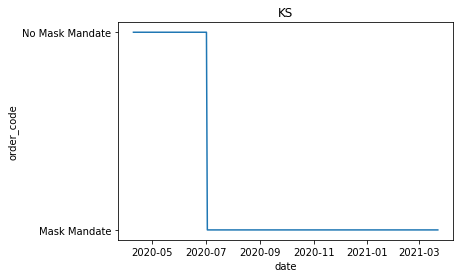

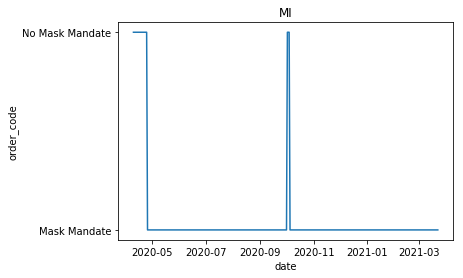

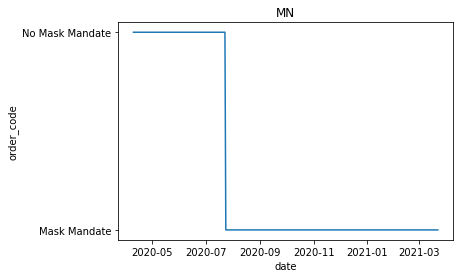

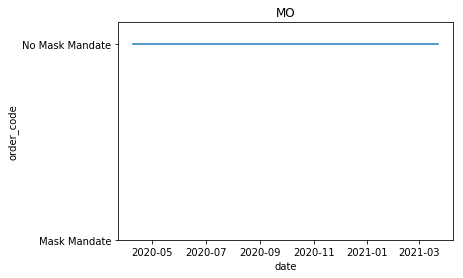

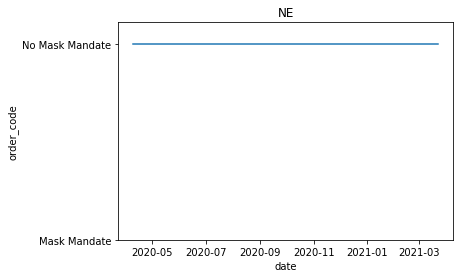

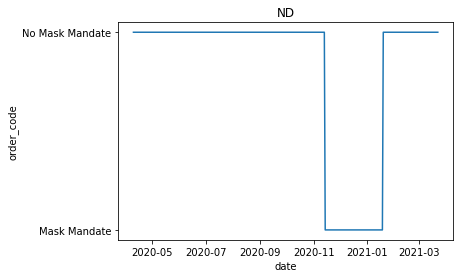

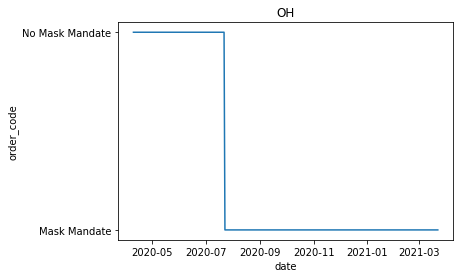

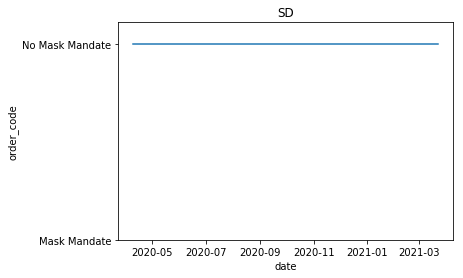

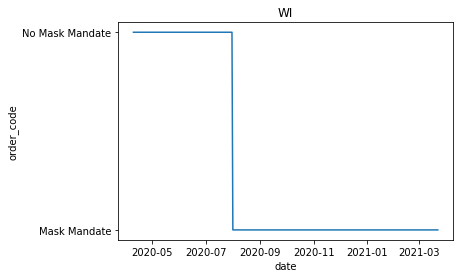

In [43]:
Midwest_Masks_df_states = Midwest_Masks_df[["date", "State_Tribe_Territory", "order_code"]].groupby(["date", "State_Tribe_Territory"]).max()
Midwest_Masks_df_states.reset_index(inplace=True)

Midwest_Masks_df_states.set_index("date", inplace=True)
for state in midwest_abbrs:
    plt.figure()
    plt_data = Midwest_Masks_df_states[Midwest_Masks_df_states["State_Tribe_Territory"]==state]
    sns.lineplot(data=plt_data, x=plt_data.index, y="order_code")
    plt.title(state)
    plt.yticks([1,2], labels=["Mask Mandate", "No Mask Mandate"])

In [44]:
# Let's investigate the random blip in Michigan
pd.set_option('display.max_rows', None)
Midwest_Masks_df[(Midwest_Masks_df["State_Tribe_Territory"]=="MI") & \
                 (Midwest_Masks_df["County_Name"]=="Alcona County") & \
                 (Midwest_Masks_df["date"] < '2020-10-10') & \
                 (Midwest_Masks_df["date"] > '2020-9-30')]
# I think this checks out against articles about the state mandate and then the Health Order

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Current_order_status,Jurisdiction_Type,Issuing_Jurisdiction,Face_Masks_Required_in_Public,Effective_date,Expiration_date,Effective_NA_Reason,Expiration_NA_Reason,Date_Signed,origin_dataset,Source_of_Action,URL,Citation
327620,MI,Alcona County,26,1,2020-10-01,1,Public Mask Mandate,State,MI,Yes,2020-09-25,NaN,NaN,Not listed,2020-09-25,state.terr,Official,https://legislature.mi.gov/documents/2019-2020...,"Mich. Exec. Order No. 2020-184 (Sept. 25, 2020)"
327621,MI,Alcona County,26,1,2020-10-02,2,No Public Mask Mandate,State,MI,No,2020-10-02,NaN,NaN,NaN,2020-10-02,state.terr,Official,https://courts.michigan.gov/Courts/MichiganSup...,In re Certified Questions from the United Stat...
327622,MI,Alcona County,26,1,2020-10-03,2,No Public Mask Mandate,State,MI,No,2020-10-02,NaN,NaN,NaN,2020-10-02,state.terr,Official,https://courts.michigan.gov/Courts/MichiganSup...,In re Certified Questions from the United Stat...
327623,MI,Alcona County,26,1,2020-10-04,2,No Public Mask Mandate,State,MI,No,2020-10-02,NaN,NaN,NaN,2020-10-02,state.terr,Official,https://courts.michigan.gov/Courts/MichiganSup...,In re Certified Questions from the United Stat...
327624,MI,Alcona County,26,1,2020-10-05,1,Public Mask Mandate,State,MI,Yes,2020-10-05,2020-10-30,NaN,NaN,2020-10-05,state.terr,Official,https://www.michigan.gov/documents/coronavirus...,"Mich. Health Order (Oct. 5, 2020)"
327625,MI,Alcona County,26,1,2020-10-06,1,Public Mask Mandate,State,MI,Yes,2020-10-05,2020-10-30,NaN,NaN,2020-10-05,state.terr,Official,https://www.michigan.gov/documents/coronavirus...,"Mich. Health Order (Oct. 5, 2020)"
327626,MI,Alcona County,26,1,2020-10-07,1,Public Mask Mandate,State,MI,Yes,2020-10-05,2020-10-30,NaN,NaN,2020-10-05,state.terr,Official,https://www.michigan.gov/documents/coronavirus...,"Mich. Health Order (Oct. 5, 2020)"
327627,MI,Alcona County,26,1,2020-10-08,1,Public Mask Mandate,State,MI,Yes,2020-10-05,2020-10-30,NaN,NaN,2020-10-05,state.terr,Official,https://www.michigan.gov/documents/coronavirus...,"Mich. Health Order (Oct. 5, 2020)"
327628,MI,Alcona County,26,1,2020-10-09,1,Public Mask Mandate,State,MI,Yes,2020-10-09,2020-10-30,NaN,NaN,2020-10-09,state.terr,Official,https://www.michigan.gov/documents/coronavirus...,"Mich. Health Order (Oct. 9, 2020)"


### Data Summary and To Dos

#### Summary
- Data is at the state level rather than the county level, which is less granular than expected, but will still be helpful
- Spotchecked for accuracy and data seems pretty consistent

#### To Do:
- Think about whether we want to use the lagged version of this for features

### Standardize data

In [45]:
Midwest_Masks_clean = Midwest_Masks_df[["State_Tribe_Territory", 
                                        "County_Name", 
                                        "FIPS_State",
                                        "FIPS_County", 
                                        "date", 
                                        "order_code"]]\
                        .rename(columns={"State_Tribe_Territory": "state", "County_Name" : "county"})\
                        .astype({'FIPS_State': 'str', 'FIPS_County': 'str'})

Midwest_Masks_clean["fips"] = Midwest_Masks_clean["FIPS_State"].str.zfill(2) + \
                                Midwest_Masks_clean["FIPS_County"].str.zfill(3)

Midwest_Masks_clean["mask_mandate"] = Midwest_Masks_clean["order_code"]*-1 + 2


Midwest_Masks_clean = Midwest_Masks_clean.drop(columns=["FIPS_State", "FIPS_County", "order_code"])

In [46]:
# Limit to four project states
Masks_clean = Midwest_Masks_clean[Midwest_Masks_clean["state"].isin(project_state_abbrs)]
np.unique(Masks_clean["state"])

array(['IL', 'MI', 'MO', 'OH'], dtype=object)

In [47]:
# remove the word " County" from county
Masks_clean.loc[:,'county'] = Masks_clean['county'].str.replace(' County','')

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [48]:
# export
Masks_clean.to_csv("../Clean Data/Masks_clean.csv", index=False)

## CMS Data on Hospital Utilization

Source: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u

Data reported on a weekly basis

I think our main variables of interest will be:
- "total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum": Sum of reports of patients currently hospitalized in an adult inpatient bed who have laboratory-confirmed or suspected COVID19. Including those in observation beds reported during the 7-day period.


- "total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum": Sum of reports of patients currently hospitalized in a pediatric inpatient bed, including NICU, PICU, newborn, and nursery, who have laboratory-confirmed COVID-19. Including those in observation beds. Including patients who have both laboratory-confirmed COVID-19 and laboratory confirmed influenza in this field reported in the 7-day period.

In [49]:
Hospitals_df_raw = pd.read_csv("../Raw Data/CMS-Hospital_Utilization.csv", 
                               parse_dates=["collection_week"], dtype={'zip': 'str', "fips_code":"str"})
Hospitals_df_raw.head()

,hospital_pk,collection_week,state,ccn,hospital_name,address,city,zip,hospital_subtype,fips_code,is_metro_micro,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg,inpatient_beds_7_day_avg,total_icu_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_avg,icu_beds_used_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_avg,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg,staffed_icu_adult_patients_confirmed_covid_7_day_avg,total_patients_hospitalized_confirmed_influenza_7_day_avg,icu_patients_confirmed_influenza_7_day_avg,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_avg,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,total_patients_hospitalized_confirmed_influenza_7_day_sum,icu_patients_confirmed_influenza_7_day_sum,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_sum,total_beds_7_day_coverage,all_adult_hospital_beds_7_day_coverage,all_adult_hospital_inpatient_beds_7_day_coverage,inpatient_beds_used_7_day_coverage,all_adult_hospital_inpatient_bed_occupied_7_day_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage,total_adult_patients_hospitalized_confirmed_covid_7_day_coverage,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage,total_pediatric_patients_hospitalized_confirmed_covid_7_day_coverage,inpatient_beds_7_day_coverage,total_icu_beds_7_day_coverage,total_staffed_adult_icu_beds_7_day_coverage,icu_beds_used_7_day_coverage,staffed_adult_icu_bed_occupancy_7_day_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage,staffed_icu_adult_patients_confirmed_covid_7_day_coverage,total_patients_hospitalized_confirmed_influenza_7_day_coverage,icu_patients_confirmed_influenza_7_day_coverage,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_coverage,previous_day_admission_adult_covid_confirmed_7_day_sum,previous_day_admission_adult_covid_confirmed_18-19_7_day_sum,previous_day_admission_adult_covid_confirmed_20-29_7_day_sum,previous_day_admission_adult_covid_confirmed_30-39_7_day_sum,previous_day_admission_adult_covid_confirmed_40-49_7_day_sum,previous_day_admission_adult_covid_confirmed_50-59_7_day_sum,previous_day_admission_adult_covid_confirmed_60-69_7_day_sum,previous_day_admission_adult_covid_confirmed_70-79_7_day_sum,previous_day_admission_adult_covid_confirmed_80+_7_day_sum,previous_day_admission_adult_covid_confirmed_unknown_7_day_sum,previous_day_admission_pediatric_covid_confirmed_7_day_sum,previous_day_covid_ED_visits_7_day_sum,previous_day_admission_adult_covid_suspected_7_day_sum,previous_day_admission_adult_covid_suspected_18-19_7_day_sum,previous_day_admission_adult_covid_suspected_20-29_7_day_sum,previous_day_admission_adult_covid_suspected_30-39_7_day_sum,previous_day_admission_adult_covid_suspected_40-49_7_day_sum,previous_day_admission_adult_covid_suspected_50-59_7_day_sum,previous_day_admission_adult

In [50]:
# filter down to relevant variables
Hospitals_df = Hospitals_df_raw.filter(items = ["collection_week",
                                                  "state",
                                                  "ccn",
                                                  "hospital_name",
                                                  "address",
                                                  "city",
                                                  "zip",
                                                  "fips_code",
                                                  "total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum",
                                                  "total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum"])

Hospitals_df = Hospitals_df.merge(Hospitals_df_raw.filter(regex = "^previous_day_admission_adult_covid_confirmed"), left_index=True, right_index=True)

Hospitals_df.columns

Index(['collection_week', 'state', 'ccn', 'hospital_name', 'address', 'city',
       'zip', 'fips_code',
       'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum',
       'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_18-19_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_20-29_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_30-39_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_40-49_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_50-59_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_60-69_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_70-79_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_80+_7_day_sum',
       'previous_day_admission_adult_covid_confirmed_unknown_7_day_sum'],
      dtype='objec

In [51]:
# shorten variable names
Hospitals_df.columns = Hospitals_df.columns\
                                   .str.replace("patients_hospitalized_confirmed_and_suspected_covid_7_day_sum",
                                                "hospitalizations")\
                                   .str.replace("previous_day_admission_adult_covid_confirmed",
                                                "prev_day_adult_admit")\
                                   .str.replace("7_day_sum", "7daysum")

In [52]:
Hospitals_df.dtypes

collection_week                         datetime64[ns]
state                                           object
ccn                                             object
hospital_name                                   object
address                                         object
city                                            object
zip                                             object
fips_code                                       object
total_adult_hospitalizations                   float64
total_pediatric_hospitalizations               float64
prev_day_adult_admit_7daysum                   float64
prev_day_adult_admit_18-19_7daysum             float64
prev_day_adult_admit_20-29_7daysum             float64
prev_day_adult_admit_30-39_7daysum             float64
prev_day_adult_admit_40-49_7daysum             float64
prev_day_adult_admit_50-59_7daysum             float64
prev_day_adult_admit_60-69_7daysum             float64
prev_day_adult_admit_70-79_7daysum             float64
prev_day_a

In [53]:
Hospitals_df.describe(datetime_is_numeric=True)

,collection_week,total_adult_hospitalizations,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum
count,184384,182031.00,181870.00,182926.00,173148.00,173866.00,174286.00,174473.00,174888.00,175330.00,175378.00,175137.00,177048.00
mean,2020-12-04 14:46:33.561263360,-69184.43,-65275.56,-193892.85,-39746.22,-172322.00,-203067.96,-229238.09,-249529.64,-255829.76,-258234.30,-254307.56,-26144.87
min,2020-07-31 00:00:00,-999999.00,-999999.00,-999999.00,-999999.00,-999999.00,-999999.00,-999999.00,-999999.00,-999999.00,-999999.00,-999999.00,-999999.00
25%,2020-10-02 00:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-999999.00,-999999.00,-999999.00,0.00
50%,2020-12-04 00:00:00,22.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2021-02-05 00:00:00,107.00,0.00,12.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,2021-04-09 00:00:00,6503.00,33045.00,1075.00,2730.00,42.00,117.00,89.00,113.00,184.00,322.00,252.00,594.00
std,NaN,253955.08,247015.60,395360.06,195363.05,377661.18,402284.04,420344.33,432743.18,436329.66,437666.67,435474.14,159568.13


Some negative numbers.  From documentation:

_Suppression is applied to the file for sums and averages less than four (4). In these cases, the field will be replaced with “-999,999”._

Let's just code that as 3 for now

In [54]:
Hospitals_df = Hospitals_df.replace(-999999., 3)

In [55]:
# looks better
Hospitals_df.describe(datetime_is_numeric=True)

,collection_week,total_adult_hospitalizations,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum
count,184384,182031.00,181870.00,182926.00,173148.00,173866.00,174286.00,174473.00,174888.00,175330.00,175378.00,175137.00,177048.00
mean,2020-12-04 14:46:33.561263360,95.12,1.97,11.08,0.20,0.71,0.97,1.28,1.99,2.61,2.71,2.44,0.63
min,2020-07-31 00:00:00,0.00,-40.00,-3.00,0.00,0.00,-1.00,-1.00,-18.00,0.00,0.00,-1.00,-33.00
25%,2020-10-02 00:00:00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2020-12-04 00:00:00,22.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2021-02-05 00:00:00,107.00,0.00,12.00,0.00,0.00,3.00,3.00,3.00,3.00,3.00,3.00,0.00
max,2021-04-09 00:00:00,6503.00,33045.00,1075.00,2730.00,42.00,117.00,89.00,113.00,184.00,322.00,252.00,594.00
std,NaN,186.44,78.37,23.38,9.50,1.57,2.02,2.51,3.93,5.09,5.48,4.95,8.20


Data only available form 7-31-2020 onwards

In [56]:
# Let's look at missingness for fips
Hospitals_df[Hospitals_df["fips_code"].isna()].groupby("state").agg({"hospital_name":"count"})

,hospital_name
state,
AK,16
AZ,8
CA,5
FL,13
HI,12
LA,111
NJ,1
NV,37
OK,6


There are some missing fips codes but luckily not for any of the states we're looking at!

In [57]:
# filter down to Midwest hospitals
hosp_midwest = Hospitals_df[Hospitals_df["state"].isin(midwest_abbrs)]
hosp_midwest.shape

(53271, 20)

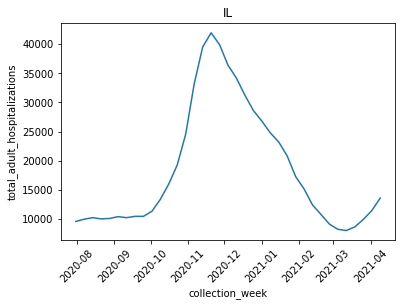

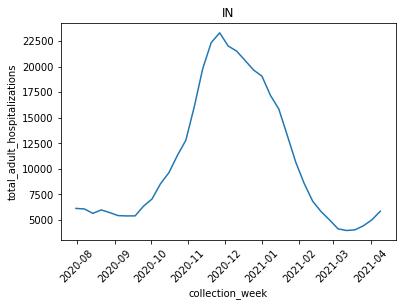

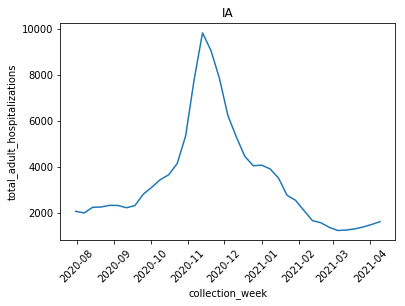

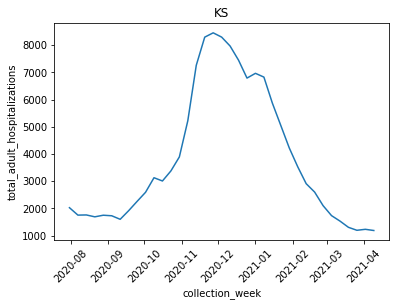

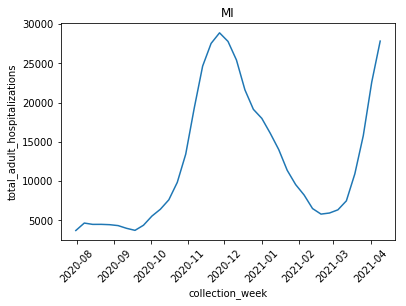

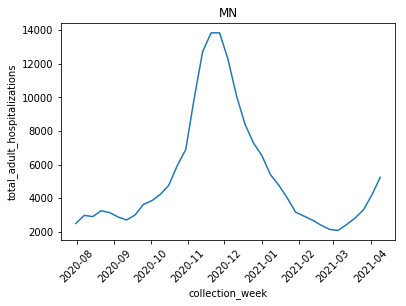

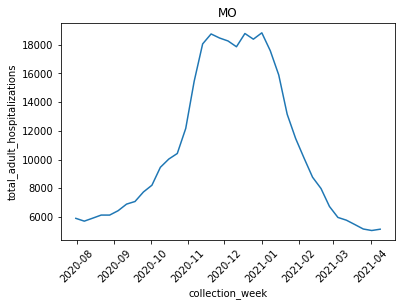

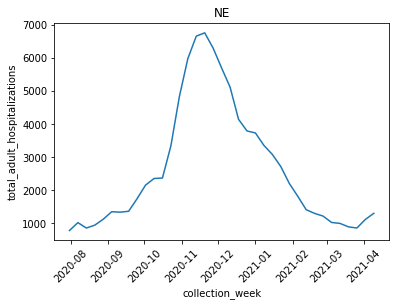

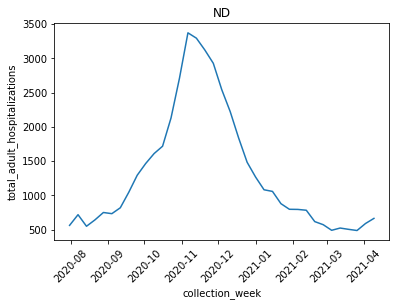

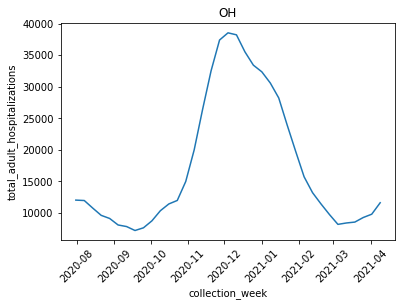

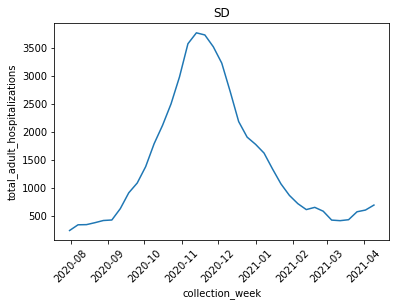

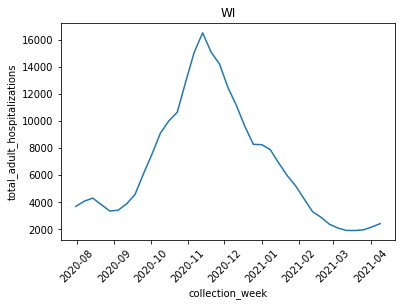

In [58]:
# aggregate and visualize at the state level
hosp_midwest_state_level = hosp_midwest.groupby(["collection_week", "state"]).agg("sum")
hosp_midwest_state_level.reset_index(inplace=True)

hosp_midwest_state_level.set_index("collection_week", inplace=True)
for state in midwest_abbrs:
    plt.figure()
    plt_data = hosp_midwest_state_level[hosp_midwest_state_level["state"]==state]
    sns.lineplot(data=plt_data, x=plt_data.index, y="total_adult_hospitalizations")
    plt.title(state)
    plt.xticks(rotation=45)

### Data Summary and To Dos

#### Summary
- Data looks generally good for using this data for one of our target variables

### Standardize Data

In [59]:
# Narrow down just two the 4 final states
Hospitals_clean = Hospitals_df[Hospitals_df["state"].isin(project_state_abbrs)]

print(Hospitals_clean.shape)

# drop some columns and group by state, date, and county
Hospital_clean = Hospitals_clean.drop(columns=["ccn", "hospital_name", "address", "city", "zip"])
Hospital_clean = Hospitals_clean.groupby(["state", "collection_week", "fips_code"]).agg("sum").reset_index()

# check format
Hospital_clean.head()

(22931, 20)


,state,collection_week,fips_code,total_adult_hospitalizations,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum
0,IL,2020-07-31,17001,85.00,0.00,15.00,0.00,3.00,0.00,3.00,3.00,3.00,7.00,3.00,0.00
1,IL,2020-07-31,17005,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,IL,2020-07-31,17011,22.00,0.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,3.00
3,IL,2020-07-31,17019,196.00,3.00,12.00,0.00,3.00,0.00,0.00,3.00,0.00,4.00,3.00,3.00
4,IL,2020-07-31,17021,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [60]:
# replicate rows so that there's one row per date instead of one row per week
from datetime import timedelta
Hospital_clean = Hospital_clean.loc[Hospital_clean.index.repeat(7)]
Hospital_clean["temp"] = Hospital_clean.groupby(['state','fips_code', 'collection_week']).cumcount()\
                                       .apply(np.ceil).apply(lambda x: pd.Timedelta(x, unit='D'))
Hospital_clean["date"] = Hospital_clean["collection_week"] + Hospital_clean["temp"]

# check to make sure things look right
Hospital_clean[Hospital_clean["fips_code"]=="17001"].head(10)

,state,collection_week,fips_code,total_adult_hospitalizations,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum,temp,date
0,IL,2020-07-31,17001,85.00,0.00,15.00,0.00,3.00,0.00,3.00,3.00,3.00,7.00,3.00,0.00,0 days,2020-07-31
0,IL,2020-07-31,17001,85.00,0.00,15.00,0.00,3.00,0.00,3.00,3.00,3.00,7.00,3.00,0.00,1 days,2020-08-01
0,IL,2020-07-31,17001,85.00,0.00,15.00,0.00,3.00,0.00,3.00,3.00,3.00,7.00,3.00,0.00,2 days,2020-08-02
0,IL,2020-07-31,17001,85.00,0.00,15.00,0.00,3.00,0.00,3.00,3.00,3.00,7.00,3.00,0.00,3 days,2020-08-03
0,IL,2020-07-31,17001,85.00,0.00,15.00,0.00,3.00,0.00,3.00,3.00,3.00,7.00,3.00,0.00,4 days,2020-08-04
0,IL,2020-07-31,17001,85.00,0.00,15.00,0.00,3.00,0.00,3.00,3.00,3.00,7.00,3.00,0.00,5 days,2020-08-05
0,IL,2020-07-31,17001,85.00,0.00,15.00,0.00,3.00,0.00,3.00,3.00,3.00,7.00,3.00,0.00,6 days,2020-08-06
76,IL,2020-08-07,17001,111.00,0.00,16.00,0.00,0.00,0.00,4.00,3.00,0.00,3.00,6.00,0.00,0 days,2020-08-07
76,IL,2020-08-07,17001,111.00,0.00,16.00,0.00,0.00,0.00,4.00,3.00,0.00,3.00,6.00,0.00,1 days,2020-08-08
76,IL,2020-08-07,17001,111.00,0.00,16.00,0.00,0.00,0.00,4.00,3.00,0.00,3.00,6.00,0.00,2 days,2020-08-09


In [61]:
# tidy up columms
Hospital_clean = Hospital_clean.drop(columns=["temp"])
Hospital_clean = Hospital_clean[Hospital_clean.columns.tolist()[-1:] + Hospital_clean.columns.tolist()[:-1]]
Hospital_clean = Hospital_clean.rename(columns={"fips_code": "fips"})
Hospital_clean = Hospital_clean.sort_values(by=["state", "fips", "date"])
Hospital_clean.head(1)

,date,state,collection_week,fips,total_adult_hospitalizations,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum
0,2020-07-31,IL,2020-07-31,17001,85.00,0.00,15.00,0.00,3.00,0.00,3.00,3.00,3.00,7.00,3.00,0.00


In [62]:
# export to Clean Data folder
Hospital_clean.to_csv("../Clean Data/Hospitals_clean.csv", index=False)

## Missouri vaccine administration data

In [63]:
MO_vaccines_raw = pd.read_csv("../Raw Data/MO_Total_Doses_by_County_data.csv", parse_dates=["Date Administered"])
MO_vaccines_raw.head()

,Date Administered,* Jurisdiction,COVID-19 Doses Administered
0,2021-04-25,Wright,13
1,2021-04-24,Wright,25
2,2021-04-23,Wright,64
3,2021-04-22,Wright,46
4,2021-04-21,Wright,46


In [64]:
MO_vaccines = MO_vaccines_raw.rename(columns={"Date Administered": "date", 
                                              "* Jurisdiction": "county",
                                              "COVID-19 Doses Administered": "doses"})

In [65]:
MO_vaccines.describe(datetime_is_numeric=True)

,date,doses
count,14253,14253.00
mean,2021-02-21 05:49:09.863186688,230.98
min,2020-12-13 00:00:00,1.00
25%,2021-01-21 00:00:00,10.00
50%,2021-02-22 00:00:00,42.00
75%,2021-03-25 00:00:00,139.00
max,2021-04-25 00:00:00,12467.00
std,NaN,743.91


data spans 12-13-2020 through 04-25-2021

In [66]:
# let's look at missingness across counties
MO_vaccines.groupby("county").agg("count")

,date,doses
county,,
Adair,128,128
Andrew,122,122
Atchison,93,93
Audrain,125,125
Barry,129,129
Barton,116,116
Bates,121,121
Benton,122,122
Bollinger,115,115


In [67]:
# let's peek at the proportion of unknown counties
unknown_county = MO_vaccines[MO_vaccines["county"]=="Unknown"][["date", "doses"]].reset_index()
known_county = MO_vaccines[MO_vaccines["county"]!="Unknown"].groupby(["date"]).agg({"doses": "sum"}).reset_index()

In [68]:
merged_county = known_county.merge(unknown_county, on=["date"], how="left")
merged_county["pct_unknown"] = merged_county["doses_y"]/merged_county["doses_x"]
merged_county.describe()

,doses_x,index,doses_y,pct_unknown
count,134.00,132.00,132.00,132.00
mean,23509.78,901.50,1075.10,0.04
std,17276.98,38.25,1131.39,0.03
min,1.00,836.00,2.00,0.00
25%,8599.75,868.75,247.25,0.02
50%,22731.50,901.50,770.00,0.04
75%,38206.00,934.25,1544.50,0.05
max,65637.00,967.00,7115.00,0.18


Looks like for the most part that the unknown counties only account for 5% of vaccinations or less, so I think we can just drop the unknown county observations

(array([737781., 737791., 737812., 737822., 737843., 737850., 737871.,
        737881., 737902., 737911.]), <a list of 10 Text xticklabel objects>)

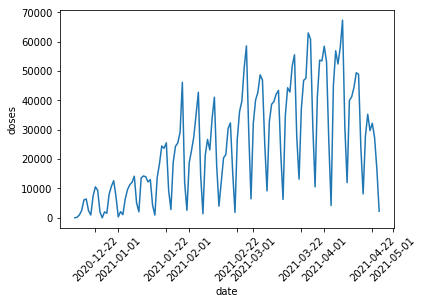

In [69]:
# aggregate and visualize at the state level
MO_vaccines["state"]="MO"
MO_vaccines_plt = MO_vaccines.groupby(["state", "date"]).agg("sum").reset_index()
sns.lineplot(data=MO_vaccines_plt, x="date", y="doses")
plt.xticks(rotation = 45)

Looks like very few vaccines get administered on Sundays.  Otherwise it looks alright.

### Standardize Data

In [70]:
# Let's drop unknown counties (since it's a small % most of the time)
MO_vaccine_clean = MO_vaccines[MO_vaccines["county"]!="Unknown"]

# Let's get a cumulative dose count

MO_vaccine_clean["cumulative doses"] = MO_vaccine_clean.sort_values(by=["state", "county", "date"])\
                                                       .groupby(['state', "county"])['doses'].cumsum(axis=0)

MO_vaccine_clean = MO_vaccine_clean.rename(columns={"doses":"new doses"})

MO_vaccine_clean.sort_values(by=["state", "county", "date"]).head(20)

MO_vaccine_clean = MO_vaccine_clean[["date","state", "county", "new doses", "cumulative doses"]]

MO_vaccine_clean = MO_vaccine_clean.sort_values(by=["state", "county", "date"]).reset_index()

MO_vaccine_clean.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,index,date,state,county,new doses,cumulative doses
0,14252,2020-12-14,MO,Adair,1,1
1,14251,2020-12-15,MO,Adair,4,5
2,14250,2020-12-16,MO,Adair,8,13
3,14249,2020-12-17,MO,Adair,16,29
4,14248,2020-12-18,MO,Adair,13,42


In [71]:
MO_county_fips_xwalk = NYT_clean[NYT_clean["state"]=="MO"][["fips", "county"]].drop_duplicates().reset_index()
MO_vaccine_clean = MO_vaccine_clean.merge(MO_county_fips_xwalk, on="county", how="left")

In [72]:
MO_vaccine_clean.loc[MO_vaccine_clean["county"]=="Kansas City", 'fips'] = "29095"
MO_vaccine_clean.loc[MO_vaccine_clean["county"]=="Joplin", 'fips'] = "29097"
MO_vaccine_clean.loc[MO_vaccine_clean["county"]=="St. Louis City", 'fips'] = "29510" # didn't get merged in the xwalk due to capitalization difference

In [73]:
MO_vaccine_clean[MO_vaccine_clean["fips"].isna()]

,index_x,date,state,county,new doses,cumulative doses,index_y,fips


In [74]:
MO_vaccine_clean = MO_vaccine_clean.drop(columns=["index_x", "index_y"])
MO_vaccine_clean.head()

,date,state,county,new doses,cumulative doses,fips
0,2020-12-14,MO,Adair,1,1,29001
1,2020-12-15,MO,Adair,4,5,29001
2,2020-12-16,MO,Adair,8,13,29001
3,2020-12-17,MO,Adair,16,29,29001
4,2020-12-18,MO,Adair,13,42,29001


In [75]:
MO_vaccine_clean.to_csv("../Clean Data/MO_vaccine_clean.csv", index=False)